In [2]:
!pip install scrapy
!pip install crochet
!pip install cloudscraper



[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip



<!DOCTYPE html>
<html data-version="klecko-" data-root="/home/cbb/build" lang="en" class="no-js" >
<head>
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />
    <link rel="dns-prefetch" href="https://cdn.ssref.net/req/202602051" />
<script>
/* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
</script>
<script src="https://cmp.osano.com/16CGnCU8UtNhM14s
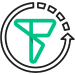
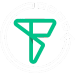

In [4]:
import requests
from scrapy import Selector

url = "https://www.sports-reference.com/cbb/players/sienna-betts-1.html"
html = requests.get(url).text
print(html)

In [ ]:
import requests
from scrapy import Selector

url = "https://www.sports-reference.com/cbb/schools/"
html = requests.get(url).text
# print(html)
sel = Selector(text=html)

# 1. Find the wrapper
wrapper = sel.css('#all_NCAAW_schools')

# 2. Try to get the comment inside
comment = wrapper.xpath('comment()').get()

if comment:
    # It was hidden! Clean it.
    clean_html = comment.replace('', '')
    table_sel = Selector(text=clean_html)
    print("Found table in comments. Unwrapping...")
else:
    # It wasn't hidden! Use the wrapper directly.
    table_sel = wrapper
    print("Table was not commented. Reading directly...")

# 3. Extract the links
links_list = [
    f"https://www.sports-reference.com{link}"
    for link in table_sel.css('td[data-stat="school_name"] a::attr(href)').getall()
]

print(links_list)

print(f"Successfully found {len(links_list)} links.")


In [ ]:
import requests
from scrapy import Selector
import pandas as pd
import re


session = requests.Session()
session.headers.update({
        "User-Agent": (
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept-Language": "en-US,en;q=0.9",
})

def get_advanced_stats_df(school_url, year, session, verbose=True):
    season_val = f"{year-1}-{str(year)[-2:]}"

    parts = [p for p in school_url.split('/') if p]
    school_slug = parts[-2] if parts[-1] == 'women' else parts[-1]
    target_url = f"{school_url.rstrip('/')}/{year}.html"

    if verbose:
        print(f"[FETCHING] {target_url}")

    try:
        resp = session.get(target_url, timeout=10)

        if resp.status_code == 429:
            print("[RATE LIMITED]")
            return "BLOCKED"
        if resp.status_code != 200:
            return pd.DataFrame()

        html_content = resp.text

        # ---- REGEX EXTRACT THE ADVANCED TABLE ----
        match = re.search(
            r'(<table[^>]*id="players_advanced"[^>]*>.*?</table>)',
            html_content,
            re.DOTALL
        )

        if not match:
            if verbose:
                print(f"[NO ADV TABLE FOUND] {target_url}")
            return pd.DataFrame()

        table_html = match.group(1)

        # ---- PARSE CLEAN TABLE HTML ----
        sel = Selector(text=table_html)
        rows = sel.css('tbody tr')

        if not rows:
            if verbose:
                print(f"[EMPTY TABLE] {target_url}")
            return pd.DataFrame()

        all_rows = []

        for row in rows:
            if row.css('th[data-stat="ranker"]::text').get() is None:
                continue

            row_data = {
                cell.attrib['data-stat']: cell.css('::text').get()
                for cell in row.css('th, td')
                if 'data-stat' in cell.attrib
            }

            player_link = row.css(
                'td[data-stat="name_display"] a::attr(href)'
            ).get()

            row_data['player_sr_link'] = (
                f"https://www.sports-reference.com{player_link}"
                if player_link else None
            )
            row_data['school'] = school_slug
            row_data['season'] = season_val

            all_rows.append(row_data)

        df = pd.DataFrame(all_rows)

        if df.empty:
            return df

        # ---- CLEANUP ----
        df = df.rename(columns={'name_display': 'player_name'})
        df = df.drop(columns=[c for c in ['ranker', 'awards'] if c in df.columns])

        first_cols = ['player_sr_link', 'player_name', 'school', 'season']
        df = df[first_cols + [c for c in df.columns if c not in first_cols]]

        return df

    except Exception as e:
        if verbose:
            print(f"[ERROR] {e}")
        return pd.DataFrame()


# get_stats_df(links_list[0], 2025)
get_advanced_stats_df(links_list[0], 2025, session)

In [7]:
import os
import time

def scrape_multi_year_data(urls, years_list, base_folder="data"):
    # Safety catch for single strings
    if isinstance(urls, str):
        urls = [urls]

    # Reverse the years list to go in reverse chronological order
    years_to_scrape = sorted(years_list, reverse=True)

    for year in years_to_scrape:
        # Create year folder (only if not exists)
        year_folder = os.path.join(base_folder, str(year))
        os.makedirs(year_folder, exist_ok=True)

        print(f"========== STARTING YEAR: {year} ==========")

        for url_idx, url in enumerate(urls):
            # Extract school slug
            parts = [p for p in url.split('/') if p]
            school_slug = parts[-2] if parts[-1] == 'women' else parts[-1]

            print(f"[{year}] Processing {url_idx + 1}/{len(urls)}: {school_slug}")

            # Fetch the data
            result = get_advanced_stats_df(url, year, session)

            # Block detection
            if isinstance(result, str) and result == "BLOCKED":
                print(f"!!! BLOCKED !!! Stopped at {school_slug} in {year}. Restart later.")
                return

            if not result.empty:
                # Path: data/2026/school_slug_wbb_2026.csv
                filename = f"{school_slug}_wbb_advanced_{year}.csv"
                file_path = os.path.join(year_folder, filename)

                # to_csv defaults to overwriting the file
                result.to_csv(file_path, index=False)
                print(f"      Saved: {file_path}")
            else:
                print(f"      No data found for {year}.")

            # The 4-second "Polite Scraper" delay
            time.sleep(4)

        print(f"========== COMPLETED YEAR: {year} ==========\n")

    print("Scrape complete.")

In [9]:
my_years = [2024]
scrape_multi_year_data(links_list, my_years)

========== COMPLETED YEAR: 2024 ==========

Scrape complete.


In [12]:
import os
import re
import time
import pandas as pd
import requests
from scrapy import Selector

# Version 1

def scrape_gamelogs_to_team_folders(
    year,
    base_folder="data",
    output_folder="gamelogs",
    sleep_time=2,
    max_retries=5,
    verbose=True,
    successCount=0,
    count=0
):
    season_folder = os.path.join(base_folder, str(year))

    if not os.path.exists(season_folder):
        print(f"[ERROR] Folder not found: {season_folder}")
        return

    session = requests.Session()
    session.headers.update({"User-Agent": "Mozilla/5.0"})

    csv_files = [f for f in os.listdir(season_folder) if f.endswith(".csv")]
    print(f"Found {len(csv_files)} school CSVs for {year}")

    for file_idx, file in enumerate(csv_files):
        file_path = os.path.join(season_folder, file)
        df = pd.read_csv(file_path)

        if "player_sr_link" not in df.columns:
            continue

        for idx, row in df.iterrows():
            count += 1
            player_url = row.get("player_sr_link")
            player_name = row.get("player_name")
            school = row.get("school")
            season = row.get("season")

            if not isinstance(player_url, str):
                continue

            safe_name = re.sub(r'[^a-zA-Z0-9_]+', '_', str(player_name))
            safe_school = re.sub(r'[^a-zA-Z0-9_]+', '_', str(school))

            # --- create team folder ---
            team_folder = os.path.join(output_folder, str(year), safe_school)
            os.makedirs(team_folder, exist_ok=True)

            output_file = os.path.join(
                team_folder,
                f"{safe_name}_{safe_school}_{year}.csv"
            )

            if os.path.exists(output_file):
                if verbose:
                    print(f"[SKIP EXISTS] {output_file}")
                continue

            player_url = player_url.replace(".html", "").rstrip("/")
            gamelog_url = f"{player_url}/gamelog/{year}"

            if verbose:
                print(f"\n[{file_idx+1}/{len(csv_files)} | player {idx+1}] {player_name}")
                print(f"[URL] {gamelog_url}")

            success = False

            for attempt in range(max_retries):
                try:
                    resp = session.get(gamelog_url, timeout=30)

                    if resp.status_code == 429:
                        print("[RATE LIMITED — sleeping 90s]")
                        time.sleep(90)
                        continue

                    if resp.status_code != 200:
                        break

                    html = resp.text
                    sel = Selector(text=html)

                    table = sel.css("table#player_game_log")

                    # --- comment tables ---
                    if not table:
                        comments = sel.xpath("//comment()").getall()
                        for c in comments:
                            if "player_game_log" in c:
                                match = re.search(
                                    r'(<table[^>]*id="player_game_log"[^>]*>.*?</table>)',
                                    c,
                                    re.DOTALL
                                )
                                if match:
                                    table_html = match.group(1)
                                    table = Selector(text=table_html)
                                    break

                    # --- regex fallback ---
                    if not table:
                        match = re.search(
                            r'(<table[^>]*id="player_game_log"[^>]*>.*?</table>)',
                            html,
                            re.DOTALL
                        )
                        if match:
                            table_html = match.group(1)
                            table = Selector(text=table_html)

                    if not table:
                        print("[NO TABLE]")
                        break

                    rows = table.css("tbody tr")
                    player_games = []

                    for r in rows:
                        if "thead" in r.attrib.get("class", ""):
                            continue

                        game = {
                            cell.attrib["data-stat"]: cell.css("::text").get()
                            for cell in r.css("th, td")
                            if "data-stat" in cell.attrib
                        }

                        game["player_name"] = player_name
                        game["player_sr_link"] = player_url + ".html" # gotta add html back so link works
                        game["school"] = school
                        game["season"] = season

                        player_games.append(game)

                    if player_games:
                        pd.DataFrame(player_games).to_csv(output_file, index=False)
                        print(f"[SAVED] {output_file}")
                        successCount += 1
                        success = True
                        break

                except requests.exceptions.ReadTimeout:
                    print(f"[TIMEOUT attempt {attempt+1}] retrying…")
                    time.sleep(10)

                except Exception as e:
                    print(f"[ERROR] {player_name}: {e}")
                    break

            if not success:
                print(f"[FAILED] {player_name}")
            print(f"{successCount}/{count} have been successfully scraped")
            time.sleep(sleep_time)

    print("\nDone scraping all players.")


In [ ]:
scrape_gamelogs_to_team_folders(year=2024)

In [ ]:
scrape_gamelogs_to_team_folders(year=2023)
scrape_gamelogs_to_team_folders(year=2022)
scrape_gamelogs_to_team_folders(year=2021)
scrape_gamelogs_to_team_folders(year=2020)
scrape_gamelogs_to_team_folders(year=2019)
scrape_gamelogs_to_team_folders(year=2018)
scrape_gamelogs_to_team_folders(year=2017)

In [22]:
import os
import re
import time
import random
import pandas as pd
import requests
from scrapy import Selector

# Version 2

def scrape_gamelogs_to_team_folders_v2(
    year,
    base_folder="data",
    output_folder="gamelogs",
    sleep_time=3,
    max_retries=3,
    verbose=True,
):
    season_folder = os.path.join(base_folder, str(year))

    if not os.path.exists(season_folder):
        print(f"[ERROR] Folder not found: {season_folder}")
        return

    session = requests.Session()
    session.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://www.sports-reference.com/"
    })

    csv_files = [f for f in os.listdir(season_folder) if f.endswith(".csv")]
    print(f"Found {len(csv_files)} school CSVs for {year}")

    success_count = 0
    fail_count = 0
    skip_count = 0
    total_attempted = 0

    for file_idx, file in enumerate(csv_files):
        file_path = os.path.join(season_folder, file)
        df = pd.read_csv(file_path)

        if "player_sr_link" not in df.columns:
            continue

        for idx, row in df.iterrows():
            total_attempted += 1

            player_url = row.get("player_sr_link")
            player_name = row.get("player_name")
            school = row.get("school")
            season = row.get("season")

            if not isinstance(player_url, str):
                continue

            safe_name = re.sub(r'[^a-zA-Z0-9_]+', '_', str(player_name))
            safe_school = re.sub(r'[^a-zA-Z0-9_]+', '_', str(school))

            team_folder = os.path.join(output_folder, str(year), safe_school)
            os.makedirs(team_folder, exist_ok=True)

            output_file = os.path.join(
                team_folder,
                f"{safe_name}_{safe_school}_{year}.csv"
            )

            if os.path.exists(output_file):
                skip_count += 1
                if verbose:
                    print(f"[SKIP EXISTS] {output_file}")
                continue

            player_url = player_url.replace(".html", "").rstrip("/")
            gamelog_url = f"{player_url}/gamelog/{year}"

            print(f"\n[{file_idx+1}/{len(csv_files)} | player {idx+1}] {player_name}")
            print(f"[URL] {gamelog_url}")

            success = False

            for attempt in range(max_retries):
                wait = 5 * (attempt + 1)

                try:
                    resp = session.get(gamelog_url, timeout=30)

                    if resp.status_code == 429:
                        print("[429 RATE LIMITED — sleeping 90s]")
                        time.sleep(90)
                        continue

                    if resp.status_code != 200:
                        print(f"[BAD STATUS {resp.status_code}] retrying")
                        time.sleep(wait)
                        continue

                    html = resp.text

                    if "Just a moment" in html:
                        print("[CLOUDFLARE BLOCK — sleeping 120s]")
                        time.sleep(120)
                        continue

                    sel = Selector(text=html)
                    table = sel.css("table#player_game_log")

                    if not table:
                        comments = sel.xpath("//comment()").getall()
                        for c in comments:
                            if "player_game_log" in c:
                                match = re.search(
                                    r'(<table[^>]*id="player_game_log"[^>]*>.*?</table>)',
                                    c,
                                    re.DOTALL
                                )
                                if match:
                                    table = Selector(text=match.group(1))
                                    break

                    if not table:
                        match = re.search(
                            r'(<table[^>]*id="player_game_log"[^>]*>.*?</table>)',
                            html,
                            re.DOTALL
                        )
                        if match:
                            table = Selector(text=match.group(1))

                    if not table:
                        print(f"[NO TABLE retry {attempt+1}]")
                        time.sleep(wait)
                        continue

                    rows = table.css("tbody tr")
                    player_games = []

                    for r in rows:
                        if "thead" in r.attrib.get("class", ""):
                            continue

                        game = {
                            cell.attrib["data-stat"]: cell.css("::text").get()
                            for cell in r.css("th, td")
                            if "data-stat" in cell.attrib
                        }

                        game["player_name"] = player_name
                        game["player_sr_link"] = player_url + ".html"
                        game["school"] = school
                        game["season"] = season

                        player_games.append(game)

                    if player_games:
                        pd.DataFrame(player_games).to_csv(output_file, index=False)
                        print(f"[SAVED] {output_file}")
                        success = True
                        success_count += 1
                        break

                except Exception as e:
                    print(f"[ERROR attempt {attempt+1}] {e}")
                    time.sleep(wait)

            if not success:
                print(f"[FAILED] {player_name}")
                fail_count += 1

            # ---- progress line ----
            print(
                f"Progress → Success: {success_count} | Failed: {fail_count} | "
                f"Skipped: {skip_count} | Total Tried: {total_attempted}"
            )

            time.sleep(sleep_time + random.uniform(1, 2))

    print("\n==========================")
    print("SCRAPE SUMMARY")
    print("==========================")
    print(f"Success: {success_count}")
    print(f"Failed: {fail_count}")
    print(f"Skipped existing: {skip_count}")
    print(f"Total attempted: {total_attempted}")


In [ ]:
scrape_gamelogs_to_team_folders_v2(year=2020)

In [23]:
scrape_gamelogs_to_team_folders_v2(year=2019, sleep_time=1)


SCRAPE SUMMARY
Success: 4453
Failed: 18
Skipped existing: 15
Total attempted: 4486
